In [ ]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind, f_oneway
from sklearn.decomposition import PCA
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size": 18, "weight": "bold"})
rc("text", usetex=True)

results_dir = "../../../LABS/ABLATION_EMB2/test_all*.csv"
combos_dir = "../../../LABS/ABLATION_EMB2/*combinations.csv"
files = glob.glob(results_dir)
combos_file = glob.glob(combos_dir)[0]
print(f"Found {len(files)} prediction files.")
params_df = pd.read_csv(combos_file)


Found 98 prediction files.


In [3]:
def get_params(id, params_df):
    return params_df[params_df["id"] == id].iloc[0]

def get_data(id, params_df=params_df, all_paths=files):
    file_path = [f for f in all_paths if f"all_{id}.csv" in f][0]
    data = pd.read_csv(file_path)
    return data, get_params(id, params_df)

def get_mape_eb(df):
    y_true = df["true_Eb"]
    y_pred = df["pred_Eb"]
    unc_pred = df["unc_Eb"]

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

def get_mape_rc(df):
    y_true = df["true_Rch"]
    y_pred = df["pred_Rch"]
    unc_pred = df["unc_Rch"]

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape



In [4]:
get_data(1)

(       N  Z  emax     pred_Eb    unc_Eb  pred_Rch   unc_Rch     true_Eb  \
 0      4  8     6  -45.434460  1.548209  1.693820  0.014922  -44.348152   
 1      4  8     6  -36.133595  1.534570  1.624560  0.015505  -36.524997   
 2      4  8     6  -49.261772  1.506482  1.679233  0.015191  -50.287001   
 3      4  8     6  -44.326336  1.497589  1.629940  0.014591  -45.166631   
 4      4  8     6  -38.356258  1.474790  1.675897  0.014461  -38.233846   
 ...   .. ..   ...         ...       ...       ...       ...         ...   
 3442  16  8    10 -146.231796  2.034716  2.840186  0.019784 -145.136932   
 3443  16  8    10 -138.271683  2.115020  2.808466  0.021200 -139.644236   
 3444  16  8    10 -134.789536  1.949867  2.862981  0.021609 -134.376866   
 3445  16  8    10 -135.951370  2.083238  2.859516  0.022358 -135.172696   
 3446  16  8    10 -129.722015  2.158148  2.819320  0.021722 -129.650261   
 
       true_Rch  
 0     1.690108  
 1     1.608634  
 2     1.673642  
 3     1.62882

In [5]:
_data = {"id": [], "mape_eb": [], "mape_rc": [], "shared_latent_dim": [], "hidden_dim": [], "n_embedding_dim": [], "fidelity_embedding_dim": []}
for id in params_df.id.unique():
    try:
        data, params = get_data(id)
        _data["id"].append(id)
        _data["mape_eb"].append(get_mape_eb(data))
        _data["mape_rc"].append(get_mape_rc(data))
        _data["shared_latent_dim"].append(params["shared_latent_dim"])
        _data["hidden_dim"].append(params["hidden_dim"])
        _data["n_embedding_dim"].append(params["n_embedding_dim"])
        _data["fidelity_embedding_dim"].append(params["fidelity_embedding_dim"])
    except:
        continue
results_df = pd.DataFrame(_data)
results_df.query("shared_latent_dim == 96").head(10)

,id,mape_eb,mape_rc,shared_latent_dim,hidden_dim,n_embedding_dim,fidelity_embedding_dim
81,82,0.834339,0.459890,96,64,20,8
82,83,0.720587,0.317768,96,64,20,8
83,84,0.967132,0.375735,96,64,20,8
84,85,0.782621,0.391550,96,64,20,8
85,86,0.638293,0.451897,96,64,20,8
86,87,0.668165,0.312219,96,64,20,8
87,89,0.873864,0.387639,96,64,20,8
88,90,0.947614,0.313845,96,64,20,8


In [ ]:
new_df = results_df.groupby("shared_latent_dim").agg({"mape_eb": ["mean", "std"], "mape_rc": ["mean", "std"]})
new_df

mape_eb             mape_rc          
                       mean       std      mean       std
shared_latent_dim                                        
8                  1.135916  0.254895  0.408100  0.072651
10                 0.976801  0.167508  0.384923  0.065749
16                 0.864857  0.104120  0.336385  0.032706
20                 0.945398  0.139845  0.390200  0.066091
24                 1.027927  0.200453  0.403814  0.068979
32                 0.893988  0.237303  0.340774  0.084496
48                 0.804571  0.234942  0.387224  0.085301
64                 0.908693  0.175393  0.387835  0.052079
80                 1.016806  0.208616  0.388420  0.054365
96                 0.804077  0.123267  0.376318  0.059157
128                0.808227  0.074618  0.403893  0.032286

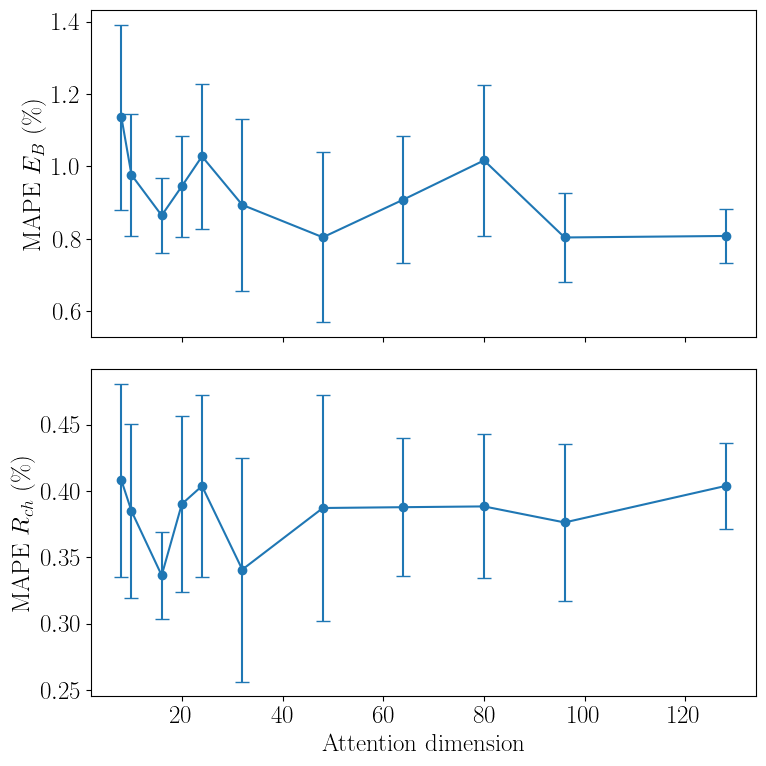

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax[0].errorbar(new_df.index, new_df["mape_eb"]["mean"], yerr=new_df["mape_eb"]["std"], label=None, fmt="o-", capsize=5)
ax[0].set_ylabel(r"MAPE $E_B$ (\%)")

ax[1].errorbar(new_df.index, new_df["mape_rc"]["mean"], yerr=new_df["mape_rc"]["std"], label=None, fmt="o-", capsize=5)
ax[1].set_ylabel("MAPE $R_{ch}$ (\%)", fontsize=18)
ax[1].set_xlabel("Attention dimension", fontsize=18)


plt.tight_layout()
plt.savefig("ablation.pdf", bbox_inches='tight')


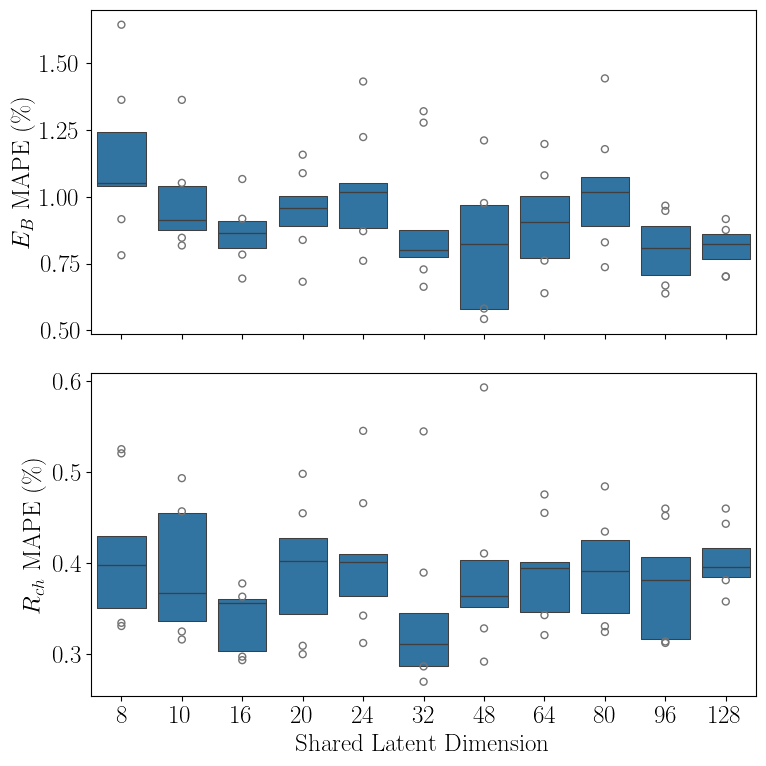

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
sns.boxenplot(x="shared_latent_dim", y="mape_eb", data=results_df, ax=ax[0])
ax[0].set_ylabel(r"$E_B$ MAPE (\%)")
sns.boxenplot(x="shared_latent_dim", y="mape_rc", data=results_df, ax=ax[1])
ax[1].set_xlabel("Shared Latent Dimension")
ax[1].set_ylabel(r"$R_{ch}$ MAPE (\%)")
plt.tight_layout()
